In [1]:
import numpy as np
import pandas as pd

from html.parser import HTMLParser
from bs4 import BeautifulSoup
import unicodedata
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import re
import nltk
nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split

from wordcloud import WordCloud, STOPWORDS

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/anirudh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/anirudh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/anirudh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Question 1: Data Cleaning

In this section, the tweets are cleaned by converting to all letters to lower cases, removing html tags and attributes, replacing html character codes, removing all URLs and removing stop words. The generic tweets dataset is cleaned first and then the Canadian Election 2019 dataset.

In [2]:
# Read data
senti = pd.read_csv('./sentiment_analysis.csv')
elec = pd.read_csv('./US_Elections_2020.csv')
print("Shape of Sentiment:",senti.shape)
print("Shape of Canadian_elections_2019:",elec.shape)

Shape of Sentiment: (550391, 3)
Shape of Canadian_elections_2019: (2552, 3)


In [3]:
senti

,ID,text,label
0,7.680980e+17,Josh Jenkins is looking forward to TAB Breeder...,1
1,7.680980e+17,RT @MianUsmanJaved: Congratulations Pakistan o...,1
2,7.680980e+17,"RT @PEPalerts: This September, @YESmag is taki...",1
3,7.680980e+17,"RT @david_gaibis: Newly painted walls, thanks ...",1
4,7.680980e+17,RT @CedricFeschotte: Excited to announce: as o...,1
...,...,...,...
550386,8.046170e+17,@goddesses_o I can't stop watching her...mm. M...,0
550387,8.046180e+17,Poor old Tom Odell doesn't look like he would ...,0
550388,8.046180e+17,#antsmasher I smashed 7 ants in this awesome ...,1
550389,8.046180e+17,@LizHudston @KymWyllie @Evasmiless @meanBok @l...,1


In [4]:

elec

,text,sentiment,negative_reason
0,"b'@robreiner so afraid of Nov, Dec, and Jan! E...",0,covid19
1,"b""RT @SueC00K: Lord Sumption launches Recovery...",0,others
2,b'RT @WalidPhares: Uber Timing: after #Biden a...,0,covid19
3,b'Every 107 seconds an American is dying from ...,1,NaN
4,b'RT @thewebbix: The #Democrats embrace #Diver...,1,NaN
...,...,...,...
2547,"b'RT @BoycottUtah: It is Friday, October 30, 2...",1,NaN
2548,b'@nowthisnews Delivered today in Montgomery C...,1,NaN
2549,b'@DonaldJTrumpJr DUHnnie Jr. lied on Fox when...,0,covid19
2550,b'RT @Pale_Ranger: Any ideas why @JoeBiden is ...,0,covid19


## Convert to lower case

In [5]:
senti_cleaned = senti[['text']].apply(lambda x: x.astype(str).str.lower())
senti_cleaned.head()

,text
0,josh jenkins is looking forward to tab breeder...
1,rt @mianusmanjaved: congratulations pakistan o...
2,"rt @pepalerts: this september, @yesmag is taki..."
3,"rt @david_gaibis: newly painted walls, thanks ..."
4,rt @cedricfeschotte: excited to announce: as o...


## Remove html tags and attributes

In [6]:
def parse(text):
    """
    remove html tags and attributes using beautifulSoup html.parser
    returns output as text
    """
    soup=BeautifulSoup(text,'html.parser')
    return soup.get_text()

In [7]:
senti_cleaned['text'] = senti_cleaned['text'].apply(parse)

In [8]:
senti_cleaned.head()

,text
0,josh jenkins is looking forward to tab breeder...
1,rt @mianusmanjaved: congratulations pakistan o...
2,"rt @pepalerts: this september, @yesmag is taki..."
3,"rt @david_gaibis: newly painted walls, thanks ..."
4,rt @cedricfeschotte: excited to announce: as o...


## Remove html character codes

In [9]:
def normalize(text):
    """
    normalizes unicode character to regular text
    """
    text=unicodedata.normalize('NFKD',text).encode('ascii', 'ignore').decode('utf-8')
    return text

In [10]:
senti_cleaned['text'] = senti_cleaned['text'].apply(normalize)

## Remove URLs

In [11]:
def remove_URL(text):
    """
    removes URL within a string by matching a pattern
    pattern: http or www until 1st white space seen
    """
    try:
        text = re.sub(r'http\S+', '', text) #match pattern http followed by any non whitespace followed by white space, replace with nothing
        text = re.sub(r'www\S+', '', text) #match pattern www followed by any non whitespace followed by white space, replace with nothing
    except:
        text = text
    return(text)

In [12]:
senti_cleaned['text'] = senti_cleaned['text'].apply(remove_URL)

## Remove stop words

A stop word is a commonly used word that a search engine has been programmed to ignore, both when indexing entries for searching and when retrieving them as the result of a search query.

We could remove these words to avoid them taking up space in our database, or taking up valuable processing time. The list of stop words used in this section is from the Natural Language Toolkit (NLTK).

In [13]:
stop_words=set(stopwords.words('english'))
# adding two stop words to the list
stop_words.add("i'm")
stop_words.add("they're")

In [14]:
def remove_stopwords(text):
    words = text.split()
    new_text = [word for word in words if word not in stop_words]
    return ' '.join(new_text)

In [15]:
senti_cleaned['text'] = senti_cleaned['text'].apply(remove_stopwords)

## Remove @ tag

In [16]:
def remove_hashtag(text):
    return re.sub(r'@.*?\s','',text)

In [17]:
senti_cleaned['text'] = senti_cleaned['text'].apply(remove_hashtag)

In [18]:
senti_cleaned.head()

,text
0,josh jenkins looking forward tab breeders crow...
1,rt congratulations pakistan becoming #no1testt...
2,"rt september, taking maine mendozas surprise t..."
3,"rt newly painted walls, thanks million custodi..."
4,rt excited announce: july 2017 feschotte lab r...


## Remove non-letter and white spaces

In [19]:
def remove_nonletter(text):
    """
    matching anything that is not in the a-z, A-Z and white space set, replace with white space
    """
    text=re.sub(r'[^a-zA-Z ]+', ' ', text)
    return text

In [20]:
senti_cleaned['text'] = senti_cleaned['text'].apply(remove_nonletter)

In [21]:
senti_cleaned.head()

,text
0,josh jenkins looking forward tab breeders crow...
1,rt congratulations pakistan becoming no testt...
2,rt september taking maine mendozas surprise t...
3,rt newly painted walls thanks million custodi...
4,rt excited announce july feschotte lab relo...


In [22]:
def remove_ws(text):
    """
    Removing extra whitespace, make all text lower case, and remove trailing and leading white spaces
    """
    text=re.sub(r'\s+', ' ', text)
    return text

In [23]:
senti_cleaned['text'] = senti_cleaned['text'].apply(remove_ws)

In [24]:
senti_cleaned.head()

,text
0,josh jenkins looking forward tab breeders crow...
1,rt congratulations pakistan becoming no testte...
2,rt september taking maine mendozas surprise th...
3,rt newly painted walls thanks million custodia...
4,rt excited announce july feschotte lab relocat...


## Lemmatization

Lemmatization uses a vocabulary and morphological analysis of the word to return it to its base form. This condenses variations of one word into its base form. It is comparatively more computationally expensive than stemming, but more accurate.

In [25]:
def lemmatization(text):
    words = word_tokenize(text)
    new_text = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(new_text)

In [26]:
senti_cleaned['text'] = senti_cleaned['text'].apply(lemmatization)

In [27]:
senti_cleaned.head()

,text
0,josh jenkins looking forward tab breeder crown...
1,rt congratulation pakistan becoming no testtea...
2,rt september taking maine mendozas surprise th...
3,rt newly painted wall thanks million custodial...
4,rt excited announce july feschotte lab relocat...


## Concat cleaned text with original data

In [28]:
senti_cleaned.columns = ['cleaned_text']
senti = pd.concat([senti, senti_cleaned], axis=1)
senti.head()

,ID,text,label,cleaned_text
0,7.680980e+17,Josh Jenkins is looking forward to TAB Breeder...,1,josh jenkins looking forward tab breeder crown...
1,7.680980e+17,RT @MianUsmanJaved: Congratulations Pakistan o...,1,rt congratulation pakistan becoming no testtea...
2,7.680980e+17,"RT @PEPalerts: This September, @YESmag is taki...",1,rt september taking maine mendozas surprise th...
3,7.680980e+17,"RT @david_gaibis: Newly painted walls, thanks ...",1,rt newly painted wall thanks million custodial...
4,7.680980e+17,RT @CedricFeschotte: Excited to announce: as o...,1,rt excited announce july feschotte lab relocat...


## Data cleaning for Canadian Election 2019 dataset

This section follows the same methods developed previously and cleans the Canadian Election 2019 dataset to satisfy the requirements.

In [29]:
elec_cleaned = elec[['text']].apply(lambda x: x.astype(str).str.lower())

In [30]:
elec_cleaned['text'] = elec_cleaned['text'].apply(parse)

/home/anirudh/anaconda3/lib/python3.8/site-packages/bs4/__init__.py:414: MarkupResemblesLocatorWarning: "https://t.co/f4y1bhld8f'" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


In [31]:
elec_cleaned['text'] = elec_cleaned['text'].apply(normalize)

In [32]:
elec_cleaned['text'] = elec_cleaned['text'].apply(remove_URL)

In [33]:
elec_cleaned['text'] = elec_cleaned['text'].apply(remove_stopwords)

In [34]:
elec_cleaned['text'] = elec_cleaned['text'].apply(remove_hashtag)

In [35]:
elec_cleaned['text'] = elec_cleaned['text'].apply(remove_nonletter)

In [36]:
elec_cleaned['text'] = elec_cleaned['text'].apply(remove_ws)

In [37]:
elec_cleaned['text'] = elec_cleaned['text'].apply(lemmatization)

In [38]:

elec_cleaned.columns = ['cleaned_text']
elec = pd.concat([elec, elec_cleaned], axis=1)
elec.head()

elec.head()


,text,sentiment,negative_reason,cleaned_text
0,"b'@robreiner so afraid of Nov, Dec, and Jan! E...",0,covid19,b afraid nov dec jan even bidenharris win frum...
1,"b""RT @SueC00K: Lord Sumption launches Recovery...",0,others,b rt lord sumption launch recovery new initiat...
2,b'RT @WalidPhares: Uber Timing: after #Biden a...,0,covid19,b rt uber timing biden advisor said would put ...
3,b'Every 107 seconds an American is dying from ...,1,NaN,b every second american dying trumpvirus n n d...
4,b'RT @thewebbix: The #Democrats embrace #Diver...,1,NaN,b rt democrat embrace diversityandinclusion ci...


# Quesyion 2: Exploratory Analysis

## Determine the political party

In [39]:
# keywords/hashtags that represent each party
# obtained from the internet consisted of political party names and leader names in various forms
conserv = ['conserv','con','andrew', 'scheer', 'andrewscheer', 'conservative', 'conservatives', 
           'cpc_hq', 'cpc', 'ford']
liberal = ['liber','lib','justin', 'trudeau', 'justintrudeau', 'liberal', 'liberals', 'timlouis', 
           'chooseforward', 'chooseforwardwithtrudeau', 'teamtrudeau', 'votingliberal']
NDP = ['ndp', 'jagmeet', 'singh', 'thejagmeetsingh', 'uprisingh']

In [40]:
# determine the political party by looking for the keywords of each party in the tweets
def LabelParty(text):
    for keyword1 in conserv:
        if text.find(keyword1)>=0:
            return "Conservative"
    for keyword2 in liberal:
        if text.find(keyword2)>=0:
            return "Liberal"
    for keyword3 in NDP:
        if text.find(keyword3)>=0:
            return "NDP"        
    return "None"

elec['Political Party'] = elec['cleaned_text'].apply(LabelParty)

elec.head()

,text,sentiment,negative_reason,cleaned_text,Political Party
0,"b'@robreiner so afraid of Nov, Dec, and Jan! E...",0,covid19,b afraid nov dec jan even bidenharris win frum...,None
1,"b""RT @SueC00K: Lord Sumption launches Recovery...",0,others,b rt lord sumption launch recovery new initiat...,None
2,b'RT @WalidPhares: Uber Timing: after #Biden a...,0,covid19,b rt uber timing biden advisor said would put ...,None
3,b'Every 107 seconds an American is dying from ...,1,NaN,b every second american dying trumpvirus n n d...,Conservative
4,b'RT @thewebbix: The #Democrats embrace #Diver...,1,NaN,b rt democrat embrace diversityandinclusion ci...,None


In [41]:
# print the distribution of the political affiliations of the tweets
elec['Political Party'].value_counts()

None            2322
Conservative     212
Liberal           17
NDP                1
Name: Political Party, dtype: int64

According to the results, there are around eight hundred of tweets mentioned something about conservative party. For liberal the number if 323 and for NDP is 112. Conservative party gets the most attention of the public, no matter negative or positive.

## Dataset visualization

### Word cloud for each dataset

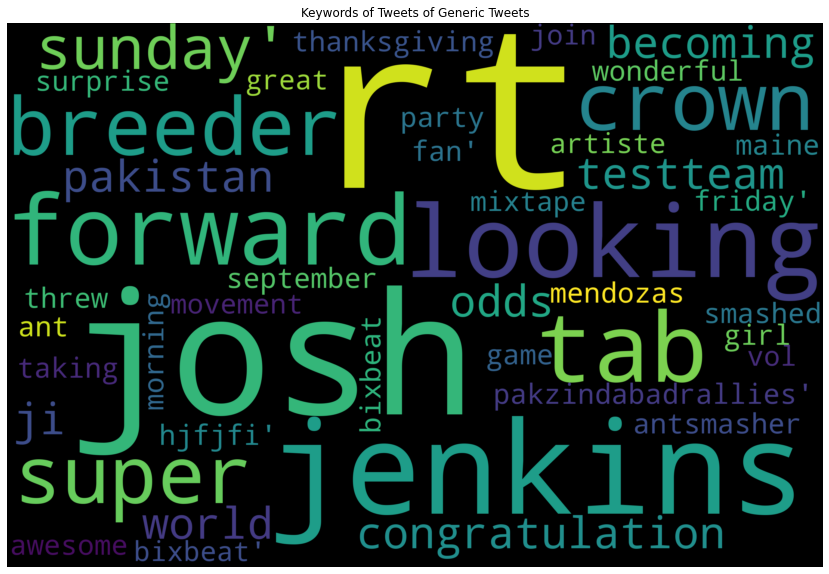

In [42]:
# word cloud for generic tweets dataset
text = senti.cleaned_text.values
senti_wordcloud = WordCloud(width = 3000, height = 2000, background_color="black").generate(str(text))

plt.figure(figsize=(20,10))
plt.imshow(senti_wordcloud, interpolation='bilinear')
plt.title('Keywords of Tweets of Generic Tweets')
plt.axis("off")
plt.show()

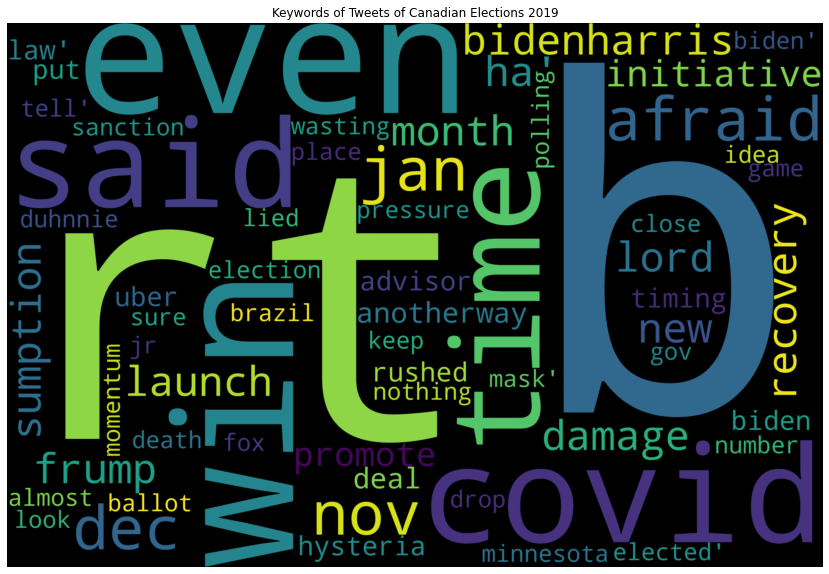

In [43]:
# word cloud for Canadian Elections 2019 dataset
text = elec.cleaned_text.values
elec_wordcloud = WordCloud(width = 3000, height = 2000, background_color="black").generate(str(text))

plt.figure(figsize=(20,10))
plt.imshow(elec_wordcloud, interpolation='bilinear')
plt.title('Keywords of Tweets of Canadian Elections 2019')
plt.axis("off")
plt.show()


From the word cloud of people's voice, we can see the frequent mentions of political party and leaders' names. There are some words such as 'suggestion', 'right', 'instead', 'going', 'strategic', 'reminder' that may show people expressing their opinions and hoping for the changes. There are also some words such as 'woman', 'allwomanspacewalk' and 'abortion' showing people concerning women productive rights.

### **BONUS**: Distribution of tweets

A bar chart is plotted in this section to visualize the distribution of the tweets with political affiliation of each party.

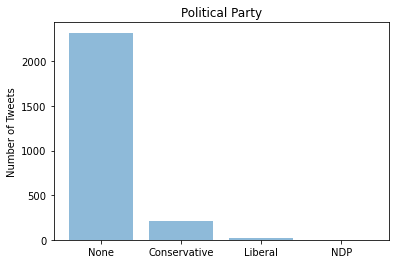

In [44]:
plt.bar(elec['Political Party'].unique(),elec['Political Party'].value_counts(), align='center', alpha=0.5)
plt.xticks(elec['Political Party'].unique())
plt.ylabel('Number of Tweets')
plt.title('Political Party')

plt.show()

### **BONUS**: Distribution of negative reasons

A pie chart is plotted to show the percentage of each negative reason with respective to the total.

In [45]:
# labels = list(elec['negative_reason'].value_counts().keys())
# sizes = list(elec['negative_reason'].value_counts().values)
# explode = (0, 0, 0, 0, 0.5, 0, 0, 0, 0, 0) 
# fig1, ax1 = plt.subplots()
# ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.2f%%', shadow=True)
# ax1.axis('equal') 
# fig = plt.gcf()
# fig.set_size_inches(20,15)
# plt.title('Reasons of Negative Tweets', fontsize=16)
# plt.show()

# Question 3: Model Preparation

## Word frequency

The technique of word frequency, as indicated by the name, represents a count of the respective word from a bag of words that are deemed most frequent. It assumes that the most important keywords occur more often than words that are not.

More information from the dataset is retained with more features. However, due to the limited RAM and running time, the maximum number of features used is 512 in this case.

In [46]:
# prepare word frequency features
corpus = senti['cleaned_text'].values.astype('U')
vectorizer_wf = CountVectorizer(max_features=512)
wf_array = vectorizer_wf.fit_transform(corpus).toarray()

wf_features = pd.DataFrame(data=wf_array, columns = vectorizer_wf.get_feature_names())
wf_features.head()

,absolutely,actually,adorable,again,ain,album,all,almost,already,also,...,would,wow,wrong,ya,year,yes,yesterday,yet,you,young
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## TF-IDF

The concept of Term Frequency-Inverse Document Frequency (TF-IDF) is different from Word Frequency that it assumes the words that appear often are in fact not important and words that appear less frequent contribute more to the overall importance.

In [47]:
# prepare TF-IDF features
vectorizer_tfidf = TfidfVectorizer(use_idf=True, smooth_idf=True, norm=None, max_features=512)
tfidf_array = vectorizer_tfidf.fit_transform(corpus).toarray()

tfidf_features = pd.DataFrame(data=tfidf_array, columns = vectorizer_tfidf.get_feature_names())
tfidf_features.head()

,absolutely,actually,adorable,again,ain,album,all,almost,already,also,...,would,wow,wrong,ya,year,yes,yesterday,yet,you,young
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Split test and training set

In [48]:
senti.drop('ID',axis=1)

,text,label,cleaned_text
0,Josh Jenkins is looking forward to TAB Breeder...,1,josh jenkins looking forward tab breeder crown...
1,RT @MianUsmanJaved: Congratulations Pakistan o...,1,rt congratulation pakistan becoming no testtea...
2,"RT @PEPalerts: This September, @YESmag is taki...",1,rt september taking maine mendozas surprise th...
3,"RT @david_gaibis: Newly painted walls, thanks ...",1,rt newly painted wall thanks million custodial...
4,RT @CedricFeschotte: Excited to announce: as o...,1,rt excited announce july feschotte lab relocat...
...,...,...,...
550386,@goddesses_o I can't stop watching her...mm. M...,0,can t stop watching her mm more
550387,Poor old Tom Odell doesn't look like he would ...,0,poor old tom odell look like would know wrong ...
550388,#antsmasher I smashed 7 ants in this awesome ...,1,antsmasher smashed ant awesome game hjfjfi
550389,@LizHudston @KymWyllie @Evasmiless @meanBok @l...,1,morning girl wonderful friday


In [49]:
senti['label'].value_counts()

1    371341
0    179050
Name: label, dtype: int64

In [50]:
# concate word frequency features with target
senti_wf_features = pd.concat([senti['label'], wf_features], axis=1)
senti_wf_features

,label,absolutely,actually,adorable,again,ain,album,all,almost,already,...,would,wow,wrong,ya,year,yes,yesterday,yet,you,young
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
550386,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
550387,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
550388,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
550389,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# split the data into 70% training and 30% testing
X_wf = senti_wf_features.drop('label', axis=1)
y_wf = senti_wf_features['label']

In [ ]:
X_wf_train, X_wf_test, y_wf_train, y_wf_test = train_test_split(X_wf, y_wf, random_state=0, test_size=0.3)

In [ ]:
# concate TF-IDF features with target and drop rows with 'Neutral' sentiment
senti_tfidf_features = pd.concat([senti['sentiment'], tfidf_features], axis=1)
senti_tfidf_features = senti_tfidf_features.drop(senti_tfidf_features[senti_tfidf_features['sentiment'] == 'Neutral'].index)

In [ ]:
# split the data into 70% training and 30% testing
X_tfidf = senti_tfidf_features.drop(['label',], axis=1)
y_tfidf = senti_tfidf_features['label']
X_tfidf_train, X_tfidf_test, y_tfidf_train, y_tfidf_test = train_test_split(X_tfidf, y_tfidf, random_state=0, test_size=0.3)

# Question 4: Model Implementation

First of all, Logistic Regression, k-NN, Naive Bayes, SVM, Decision Trees, Random Forest and XGBoost models are trained and applied to the test data. Note that each model is trained twice with word frequency features and TF-IDF features. The accuracy values are obtained and printed.

## Logistic regression model

In [ ]:
from sklearn.linear_model import LogisticRegression

### Word frequency features

In [ ]:
wf_logistic_model = LogisticRegression()
wf_logistic_model.fit(X_wf_train,y_wf_train)

In [ ]:
wf_logistic_predict = wf_logistic_model.predict(X_wf_test)
wf_logistic_accuracy = accuracy_score(y_wf_test, wf_logistic_predict)
print("The accuracy of logistic regression model with word frequency features is:{}%".format(round(wf_logistic_accuracy*100, 3)))

### TF-IDF features

In [ ]:
tfidf_logistic_model = LogisticRegression()
tfidf_logistic_model.fit(X_tfidf_train,y_tfidf_train)


In [ ]:
tfidf_logistic_predict = tfidf_logistic_model.predict(X_tfidf_test)
tfidf_logistic_accuracy = accuracy_score(y_tfidf_test, tfidf_logistic_predict)
print("The accuracy of logistic regression model with TF-IDF features is:{}%".format(round(tfidf_logistic_accuracy*100, 3)))

## k-NN model

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

### Word frequency features

In [ ]:
wf_knn_model = KNeighborsClassifier()
wf_knn_model.fit(X_wf_train,y_wf_train)

In [ ]:
wf_knn_predict = wf_knn_model.predict(X_wf_test)
wf_knn_accuracy = accuracy_score(y_wf_test, wf_knn_predict)
print("The accuracy of k-NN model with word frequency features is:{}%".format(round(wf_knn_accuracy*100, 3)))

### TF-TDF features

In [ ]:
tfidf_knn_model = KNeighborsClassifier()
tfidf_knn_model.fit(X_tfidf_train,y_tfidf_train)

In [ ]:
tfidf_knn_predict = tfidf_knn_model.predict(X_tfidf_test)
tfidf_knn_accuracy = accuracy_score(y_tfidf_test, tfidf_knn_predict)
print("The accuracy of k-NN model with TF-IDF features is:{}%".format(round(tfidf_knn_accuracy*100, 3)))

## Naive bayes model

In [ ]:
from sklearn.naive_bayes import GaussianNB

### Word frequency features

In [ ]:
wf_naive_model = GaussianNB()
wf_naive_model.fit(X_wf_train,y_wf_train)

In [ ]:
wf_naive_predict = wf_naive_model.predict(X_wf_test)
wf_naive_accuracy = accuracy_score(y_wf_test, wf_naive_predict)
print("The accuracy of Naive Bayes model with word frequency features is:{}%".format(round(wf_naive_accuracy*100, 3)))

### TF-IDF features

In [ ]:
tfidf_naive_model = GaussianNB()
tfidf_naive_model.fit(X_tfidf_train,y_tfidf_train)

In [ ]:
tfidf_naive_predict = tfidf_naive_model.predict(X_tfidf_test)
tfidf_naive_accuracy = accuracy_score(y_tfidf_test, tfidf_naive_predict)
print("The accuracy of Naive Bayes model with TF-IDF features is:{}%".format(round(tfidf_naive_accuracy*100, 3)))

## SVM

In [ ]:
from sklearn.svm import SVC

### Word frequency features

In [ ]:
wf_svm_model = SVC()
wf_svm_model.fit(X_wf_train,y_wf_train)

In [ ]:
wf_svm_predict = wf_svm_model.predict(X_wf_test)
wf_svm_accuracy = accuracy_score(y_wf_test, wf_svm_predict)
print("The accuracy of SVM model with word frequency features is:{}%".format(round(wf_svm_accuracy*100, 3)))

### TF-IDF features

In [ ]:
tfidf_svm_model = SVC()
tfidf_svm_model.fit(X_tfidf_train,y_tfidf_train)

In [ ]:
tfidf_svm_predict = tfidf_svm_model.predict(X_tfidf_test)
tfidf_svm_accuracy = accuracy_score(y_tfidf_test, tfidf_svm_predict)
print("The accuracy of SVM model with TF-IDF features is:{}%".format(round(tfidf_svm_accuracy*100, 3)))

## Decision trees model

In [ ]:
from sklearn.tree import DecisionTreeClassifier

### Word frequency features

In [ ]:
wf_dt_model = DecisionTreeClassifier(random_state = 0)
wf_dt_model.fit(X_wf_train,y_wf_train)

In [ ]:
wf_dt_predict = wf_dt_model.predict(X_wf_test)
wf_dt_accuracy = accuracy_score(y_wf_test, wf_dt_predict)
print("The accuracy of Decision Trees model with word frequency features is:{}%".format(round(wf_dt_accuracy*100, 3)))

### TF-IDF features

In [ ]:
tfidf_dt_model = DecisionTreeClassifier(random_state = 0)
tfidf_dt_model.fit(X_tfidf_train,y_tfidf_train)

In [ ]:
tfidf_dt_predict = tfidf_svm_model.predict(X_tfidf_test)
tfidf_dt_accuracy = accuracy_score(y_tfidf_test, tfidf_dt_predict)
print("The accuracy of Decision Trees model with TF-IDF features is:{}%".format(round(tfidf_dt_accuracy*100, 3)))

## Random forest model

In [ ]:
from sklearn.ensemble import RandomForestClassifier

### Word frequency features

In [ ]:
wf_rf_model = RandomForestClassifier()
wf_rf_model.fit(X_wf_train,y_wf_train)

In [ ]:
wf_rf_predict = wf_rf_model.predict(X_wf_test)
wf_rf_accuracy = accuracy_score(y_wf_test, wf_rf_predict)
print("The accuracy of Random Forest model with word frequency features is:{}%".format(round(wf_rf_accuracy*100, 3)))

### TF-IDF features

In [ ]:
tfidf_rf_model = DecisionTreeClassifier()
tfidf_rf_model.fit(X_tfidf_train,y_tfidf_train)

In [ ]:
tfidf_rf_predict = tfidf_rf_model.predict(X_tfidf_test)
tfidf_rf_accuracy = accuracy_score(y_tfidf_test, tfidf_rf_predict)
print("The accuracy of Random Forest model with TF-IDF features is:{}%".format(round(tfidf_rf_accuracy*100, 3)))

## XGBoost 

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

### Word frequency features

In [ ]:
wf_xgb_model = GradientBoostingClassifier(random_state = 0)
wf_xgb_model.fit(X_wf_train,y_wf_train)

In [ ]:
wf_xgb_predict = wf_rf_model.predict(X_wf_test)
wf_xgb_accuracy = accuracy_score(y_wf_test, wf_xgb_predict)
print("The accuracy of XGBoost model with word frequency features is:{}%".format(round(wf_xgb_accuracy*100, 3)))

### TF-IDF features

In [ ]:
tfidf_xgb_model = GradientBoostingClassifier(random_state = 0)
tfidf_xgb_model.fit(X_tfidf_train,y_tfidf_train)

In [ ]:
tfidf_xgb_predict = tfidf_xgb_model.predict(X_tfidf_test)
tfidf_xgb_accuracy = accuracy_score(y_tfidf_test, tfidf_xgb_predict)
print("The accuracy of XGBoost model with TF-IDF features is:{}%".format(round(tfidf_xgb_accuracy*100, 3)))

## Results comparison

In [ ]:
model_name = np.array([['Logistic Regression'], ['k-NN'], ['Naive Bayes'], ['SVM'], ['Decision Trees'],
                       ['Random Forest'], ['XGBoost']])
wf_accuracy = np.array([[round(wf_logistic_accuracy*100, 3)], [round(wf_knn_accuracy*100, 3)],
              [round(wf_naive_accuracy*100, 3)], [round(wf_svm_accuracy*100, 3)],
              [round(wf_dt_accuracy*100, 3)], [round(wf_rf_accuracy*100, 3)],
              [round(wf_xgb_accuracy*100, 3)]])
tfidf_accuracy = np.array([[round(tfidf_logistic_accuracy*100, 3)], [round(tfidf_knn_accuracy*100, 3)],
              [round(tfidf_naive_accuracy*100, 3)], [round(tfidf_svm_accuracy*100, 3)],
              [round(tfidf_dt_accuracy*100, 3)], [round(tfidf_rf_accuracy*100, 3)],
              [round(tfidf_xgb_accuracy*100, 3)]])  
summary_np = np.concatenate((model_name, wf_accuracy, tfidf_accuracy), axis=1) 
summary = pd.DataFrame(summary_np)
summary.columns = ['Model', 'Word Frequency Features', 'TF-IDF Features']
summary

### Model with best performance

According to the summary table, SVM model and Decision Trees model with TF-IDF features both yield the highest accuracy of 72.695%. The SVM model is selected for it has a higher average accuracy (among WF features and TF-IDF features). In this case, the model will be used in the following section is the SVM model with TF-IDF features.

### Hyperparameter tuning

The SVM model takes extremely long to fit and predict. With grid search, the expected running time would be around 50 times longer, not to mention that the cross-validation will further lengthen the running time.

In this case, the hyperparameter tuning is skipped (but code is still available below) and the default parameters are used for the SVM model.

In [ ]:
#param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}
#grid = GridSearchCV(tfidf_svm_model(),param_grid,cv=10,refit=True,verbose=2)
#grid.fit(X_tfidf_train,y_tfidf_train)

In [ ]:
#print(grid.best_estimator_)

## Sentiments prediction results

In this section, the best model (SVM with TF-IDF features) is implemented on the **entire** Canadian Election dataset to get prediction results on sentiments.

In [ ]:
corpus_elec = elec['cleaned_text'].values.astype('U')
vectorizer_tfidf = TfidfVectorizer(use_idf=True, smooth_idf=True, norm=None, max_features=512)
elec_tfidf_array = vectorizer_tfidf.fit_transform(corpus_elec).toarray()

elec_tfidf_features = pd.DataFrame(data=elec_tfidf_array, columns = vectorizer_tfidf.get_feature_names())
elec_tfidf_features.head()

In [ ]:
elec_tfidf_features = pd.concat([elec['sentiment'], elec_tfidf_features], axis=1)

In [ ]:
elec_tfidf_features['labels'] = elec_tfidf_features['sentiment'].map(label_encoding)
elec_tfidf_features = elec_tfidf_features.drop(['sentiment'],axis=1)

In [ ]:
X_elec_tfidf = elec_tfidf_features.drop(['labels',], axis=1)
y_elec_tfidf = elec_tfidf_features['labels']

In [ ]:
elec_tfidf_svm_predict = tfidf_svm_model.predict(X_elec_tfidf)
elec_tfidf_svm_accuracy = accuracy_score(y_elec_tfidf, elec_tfidf_svm_predict)
print("The accuracy of SVM model with TF-IDF features is:{}%".format(round(elec_tfidf_svm_accuracy*100, 3)))

The accuracy of the model is only about 50% meaning that it only correctly predicts half of the sentiments, which is a comparatively poor model accuracy.

## Visualisation of the results for the three parties

A classification report is printed for the prediction of each party and a confusion matrix is plotted as well.

### Liberal

In [ ]:
elec['predict'] = elec_tfidf_svm_predict
elec['labels'] = elec_tfidf_features['labels']

In [ ]:
lib_visual = elec[elec['Political Party'] == 'Liberal']
lib_test = lib_visual['labels']
lib_pred = lib_visual['predict']

In [ ]:
from sklearn.metrics import classification_report
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns  

print(classification_report(lib_test,lib_pred))
cm=metrics.confusion_matrix(lib_test, lib_pred)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap="Blues", fmt='g'); #annot=True to annotate cells

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Canadian Election Tweets Sentiment Prediction for Liberal'); 
ax.xaxis.set_ticklabels(['Negative','Positive']); ax.yaxis.set_ticklabels(['Negative','Positive']);

### Conservative

In [ ]:
con_visual = elec[elec['Political Party'] == 'Conservative']
con_test = con_visual['labels']
con_pred = con_visual['predict']

In [ ]:
print(classification_report(con_test,con_pred))
cm=metrics.confusion_matrix(con_test,con_pred)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap="Blues", fmt='g'); #annot=True to annotate cells

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Canadian Election Tweets Sentiment Prediction for Conservative'); 
ax.xaxis.set_ticklabels(['Negative','Positive']); ax.yaxis.set_ticklabels(['Negative','Positive']);

### NDP

In [ ]:
ndp_visual = elec[elec['Political Party'] == 'NDP']
ndp_test = ndp_visual['labels']
ndp_pred = ndp_visual['predict']

In [ ]:
print(classification_report(ndp_test,ndp_pred))
cm=metrics.confusion_matrix(ndp_test,ndp_pred)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap="Blues", fmt='g'); #annot=True to annotate cells

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Canadian Election Tweets Sentiment Prediction for NDP'); 
ax.xaxis.set_ticklabels(['Negative','Positive']); ax.yaxis.set_ticklabels(['Negative','Positive']);

### Discussion

The prediction accuracy 0.51 for liberal, 0.55 for conservative and 0.46 for NDP. The lower accuracy for that of NDP might be attributed to its smaller sample size as it has the fewest number of tweets when determining the political party.

For the three parties, in general, the predicted negative tweets are always more than the actual negative tweets. It is also clear from the confusion matrix that there are more 'false negative' than 'false positive' for all three parties.

The model performance is considered as poor mainly because of its low accuracy. The accuracy is only about 50%, which is equal to a random selection probability as there are only two possible outcomes (binary). In this case, the NLP analysis can be concluded as **not useful** for political parties. It may help the leaders to get insights on what the public think about their plans and strategies, but it does not really give an accurate prediction of the sentiments.

## Predict reasons for negative tweets

The three models selected to predict the reasons for negative tweets are:


1.   Logistic Regression
2.   SVM
3.   Decision Trees

The three models are selected for they had the highest accuracy in model implementation section.

### Label encoding

In [ ]:
elec_nega = pd.concat([elec['negative_reason'],elec_tfidf_features], axis=1)
elec_nega = elec_nega[elec_nega['labels'] == 0]
elec_nega = elec_nega.drop(['labels'], axis = 1)

In [ ]:
elec_nega['negative_reason'].value_counts()

In [ ]:
nega_label={'Others':0,'Scandal':1,'Tell lies':2, 'Economy':3, 'Women Reproductive right and Racism':4, 
            'Climate Problem':5, 'Separation':6, 'Privilege':7, 'Healthcare':8, 
            'Healthcare and Marijuana':8}

In [ ]:
elec_nega['reason_encoded'] = elec_nega['negative_reason'].map(nega_label)
elec_nega = elec_nega.drop(['negative_reason'],axis=1)

### Split test and training set

In [ ]:
X = elec_nega.drop(['reason_encoded'],axis=1)
y = elec_nega['reason_encoded']

# split the test train data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=55)

### Logistic regression

In [ ]:
nega_logistic_model = LogisticRegression()
nega_logistic_model.fit(X_train,y_train)

In [ ]:
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')
nega_logistic_predict = nega_logistic_model.predict(X_test)
nega_logistic_accuracy = accuracy_score(y_test, nega_logistic_predict)
nega_logistic_scores = cross_val_score(nega_logistic_model, X_train, y_train, cv=10)

In [ ]:
print("Cross Validation Accuracy: %0.3f (+/- %0.3f)" % (nega_logistic_scores.mean(), nega_logistic_scores.std() * 2))
print ('Prediction Accuracy Score: ' + str(round(nega_logistic_accuracy,3)*100) +'%')
print ('\n')
print(classification_report(y_test,nega_logistic_predict))

### SVM

In [ ]:
nega_svm_model = SVC()
nega_svm_model.fit(X_train,y_train)

In [ ]:
nega_svm_predict = nega_svm_model.predict(X_test)
nega_svm_accuracy = accuracy_score(y_test, nega_svm_predict)
nega_svm_scores = cross_val_score(nega_svm_model, X_train, y_train, cv=10)

In [ ]:
print("Cross Validation Accuracy: %0.3f (+/- %0.3f)" % (nega_svm_scores.mean(), nega_svm_scores.std() * 2))
print ('Prediction Accuracy Score: ' + str(round(nega_svm_accuracy,3)*100) +'%')
print ('\n')
print(classification_report(y_test,nega_svm_predict))

### Decision trees

In [ ]:
nega_dt_model = DecisionTreeClassifier(random_state = 0)
nega_dt_model.fit(X_train,y_train)

In [ ]:
nega_dt_predict = nega_dt_model.predict(X_test)
nega_dt_accuracy = accuracy_score(y_test, nega_dt_predict)
nega_dt_scores = cross_val_score(nega_dt_model, X_train, y_train, cv=10)

In [ ]:
print("Cross Validation Accuracy: %0.3f (+/- %0.3f)" % (nega_dt_scores.mean(), nega_dt_scores.std() * 2))
print ('Prediction Accuracy Score: ' + str(round(nega_dt_accuracy,3)*100) +'%')
print ('\n')
print(classification_report(y_test,nega_dt_predict))

### Results

The model with highest accuracy is the Logistic Regression Model and the accuracy is 50.7%.

# Question 5: Results comparison

## First model

In [ ]:
lib_visual = elec[elec['Political Party'] == 'Liberal']
lib_pos_gt = lib_visual['labels'].sum()
lib_neg_gt = lib_visual.shape[0] - lib_pos_gt
lib_pos_pr = lib_visual['predict'].sum()
lib_neg_pr = lib_visual.shape[0] - lib_pos_pr

con_visual = elec[elec['Political Party'] == 'Conservative']
con_pos_gt = con_visual['labels'].sum()
con_neg_gt = con_visual.shape[0] - con_pos_gt
con_pos_pr = con_visual['predict'].sum()
con_neg_pr = con_visual.shape[0] - con_pos_pr

ndp_visual = elec[elec['Political Party'] == 'NDP']
ndp_pos_gt = ndp_visual['labels'].sum()
ndp_neg_gt = ndp_visual.shape[0] - ndp_pos_gt
ndp_pos_pr = ndp_visual['predict'].sum()
ndp_neg_pr = ndp_visual.shape[0] - ndp_pos_pr

pos_gt_list = [lib_pos_gt, con_pos_gt, ndp_pos_gt]
neg_gt_list = [lib_neg_gt, con_neg_gt, ndp_neg_gt]
pos_pr_list = [lib_pos_pr, con_pos_pr, ndp_pos_pr]
neg_pr_list = [lib_neg_pr, con_neg_pr, ndp_neg_pr]

In [ ]:
# plot the bar chart
fig, ax = plt.subplots()
index = np.arange(3)
bar_width = 0.35
opacity = 0.8

plt.bar(index, pos_gt_list, bar_width, alpha=opacity, 
        color='#2ECC71', label='Label Positive')
plt.bar(index + bar_width, pos_pr_list, bar_width, alpha=opacity, 
        color='#82E0AA', label='Predicted Positive')
plt.bar(index, neg_gt_list, bar_width, alpha=opacity, bottom=pos_gt_list,
        color='#E74C3C', edgecolor='white', label='Label Negative')
plt.bar(index + bar_width, neg_pr_list, bar_width, alpha=opacity, bottom=pos_pr_list,
        color='#F1948A', edgecolor='white', label='Predicted Negative')

plt.xlabel('Political Party')
plt.ylabel('Number of Tweets')
plt.title('Election Sentiment Analysis')
plt.xticks(index + bar_width/2, ('LIB', 'CON', 'NDP'))
plt.legend()

plt.tight_layout()
plt.show()

What can public opinion on Twitter tell us about the Canadian political landscape in 2019?


1.   Many people talk about the election but without mentioning any specific party. It is possible that these people do not have any inclination in which party they are going to vote for, or they might be talking about political parties other than the three classified in the analysis.
2.   Among the three major political parties (Liberal, Conservative and NDP), the Conservative Party of Canada received the most tweets. This makes sense as the party has very popular votes. Liberal is the second as it stands on the opposite side to the Conservative Party.
3.   Among the entire dataset, the positive tweets and negative tweets are about half to half, which results in a comparatively balanced dataset.

How each party is viewed in the public eye?


1.   Liberal Party: Positive tweets and negative tweets are about the similar amount, indicating that the overall sentiment towards the party is fairly neutral.
2.   Conservative Party: There are more negative tweets mentioning the party than negative ones, meaning more dissatisfaction is discovered on Twitter towards the party.
3.   NDP: Fewer tweets mentioned the party, indicating less attention from the public, however, the party received twice more positive tweets than negative ones.

How to improve the accuracy of the model?


1.   Include more features when developing word frequency and TF-IDF feature set
2.   Use larger and more relevant dataset (i.e. last year election data) to train the model
3.   Include more keywords when determining political party
4.   Implement more sophisticated models of NLP







## Second model

Why the model may fail to predict the correct negative reasons?


1.   The sample size is too small. There is not sufficient data for training the model.
2.   About 1/3 of the negative reason is 'Other', which does not help to classify the specific negative reason.
3.   Some tweets belong to one class of negative reason do not necessarily mention the keywords for classfying that negative reason and thus will reduce accuracy.

How to improve the accuracy of the model?


1.   Augment the dataset to include more tweets with negative reasons other than 'Other'



